**Part 2. AI Agent 활용 프로젝트**

- Chapter 02. 컨텍스트 품질을 보장하는 RAG

    - **📒[실습]** Clip 02. 검색 문서의 관련성 검증을 추가한 RAG (Human-in-the-loop)🗒️

In [3]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("OPENAI_API_KEY")

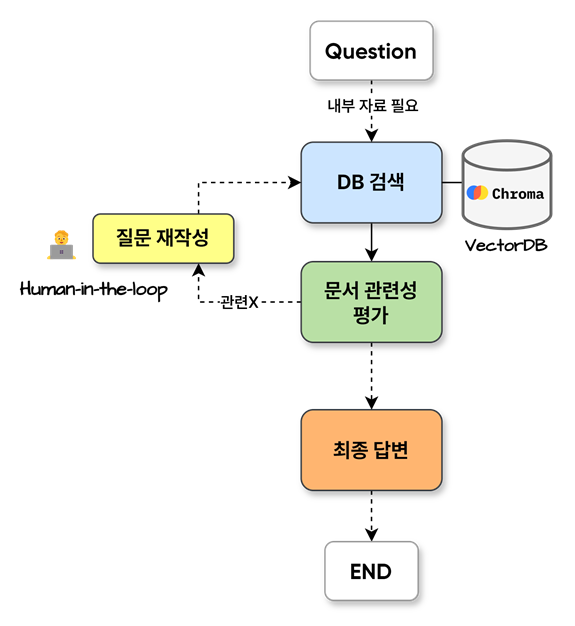

## 🗄️ Vector DB (문서 검색을 위한 Retriever 생성하기)

https://spri.kr/posts?code=AI-Brief

In [4]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_experimental.text_splitter import SemanticChunker
from langchain_openai.embeddings import OpenAIEmbeddings

file_path = "SPRi AI Brief_4월호_산업동향_250407_F.pdf"

loader = PyPDFLoader(file_path)
pages = []

async for page in loader.alazy_load():
    pages.append(page)

text_splitter = SemanticChunker(OpenAIEmbeddings())

docs = text_splitter.split_documents(pages)

In [5]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

vectorstore = Chroma.from_documents(documents=docs, embedding=OpenAIEmbeddings())

In [6]:
retriever = vectorstore.as_retriever(search_kwargs={"k": 1})

In [7]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_ai_trends",
    "Search and return information from the April 2025 AI Policy Report, including global AI policies, legal regulations, major industry updates, technical research, education trends, and government strategies related to AI development.",
)

tools = [retriever_tool]

## 👉 Graph 

### Step 0. Graph State

In [8]:
from typing import Annotated, Literal, Sequence

from langchain_core.messages import BaseMessage
from langgraph.graph.message import add_messages
from langgraph.graph import MessagesState


class State(MessagesState):
    questions: Annotated[Sequence[BaseMessage], add_messages]

In [9]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o", temperature=0)

### Step 1. 문서 검색 도구(retriever)를 호출 (bind_tools)

In [10]:
def agent(state: State):
    """
    Invokes the agent model to generate a response based on the current state. Given
    the question, it will decide to retrieve using the retriever tool, or simply end.
    """
    print("##### HI ! #####")
    messages = state["messages"]
    llm_with_tools = llm.bind_tools(tools) # , tool_choice="any"
    response = llm_with_tools.invoke(messages)

    return {"messages": [response]} # tool_calls / AI Messages


### Step 2. 문서 관련성 평가

In [11]:
from pydantic import BaseModel, Field

class grade(BaseModel):
    """Binary score for relevance check."""

    binary_score: str = Field(description="Relevance score 'yes' or 'no'")

In [12]:
from langchain import hub
from langchain_core.prompts import ChatPromptTemplate

from langgraph.prebuilt import tools_condition
from langgraph.types import Command, interrupt


def grade_documents(state: State) -> Literal["generate", "rewrite"]:
    """
    Determines whether the retrieved documents are relevant to the question.
    """

    print("##### CHECK RELEVANCE #####")

    grader = llm.with_structured_output(grade)

    grader_prompt = ChatPromptTemplate.from_template(
        """
        You are a grader assessing relevance of a retrieved document to a user question. \n 
        Here is the retrieved document: \n\n {context} \n\n
        Here is the user question: {question} \n
        If the user question is too short, vague, or lacks enough context to clearly determine intent, grade it as not relevant and RETURN "no" \n
        Give a binary score 'yes' or 'no' score to indicate whether the document is relevant to the question.
        """
    )

    chain = grader_prompt | grader

    if len(state["questions"]) > 0: # 질문 재 작성 n회차 입력
        question = state["questions"][-1].content
    else: # 최초 입력
        question = state["messages"][0].content

    docs = state["messages"][-1].content

    print("question", question)
    print("context", docs)

    scored_result = chain.invoke({"question": question, "context": docs})

    score = scored_result.binary_score # yes or no

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generate"

    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        print(score)
        return "rewrite"

### Step 3. 사용자로부터 새로운 쿼리를 입력받는 Human-in-the-loop

In [13]:
from langchain_core.messages import HumanMessage

def rewrite(state: State):
    """
    Rewrite the query to produce a better question. (Human-in-the-loop)
    """
    print("\n🤖 검색 결과를 개선하기 위해 더 명확한 의도를 포함하여 질문을 다시 해주세요!:")
    feedback = interrupt("New Question:")
    print("feedback", feedback)
    return {"messages": [feedback], "questions": [HumanMessage(content=feedback)]}

### Step 4. 새로운 쿼리와 검색된 문서를 기반으로 최종 답변

In [14]:
def generate(state: State):
    """
    Generate answer
    """
    print("##### GENERATE #####")
    if len(state["questions"]) > 0: # 질문 재 작성 n회차 입력
        question = state["questions"][-1].content
    else: # 최초 입력
        question = state["messages"][0].content
    docs = state["messages"][-1].content

    prompt = hub.pull("rlm/rag-prompt")

    response = llm.invoke(
        prompt.format_messages(context=docs, question=question)
    )
    print("response", response)
    return {"messages": [response]}

### Step 5. Graph Compile!

In [15]:
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

graph_builder = StateGraph(State)

graph_builder.add_node("agent", agent) 
retrieve = ToolNode([retriever_tool])
graph_builder.add_node("retrieve", retrieve)

graph_builder.add_edge(START, "agent")
graph_builder.add_conditional_edges(
    "agent",
    tools_condition,
    {
        "tools": "retrieve",
        END: END,
    },
)

In [16]:
graph_builder.add_node("rewrite", rewrite) 
graph_builder.add_node("generate", generate)


graph_builder.add_conditional_edges(
    "retrieve",
    grade_documents,
)
graph_builder.add_edge("generate", END)
graph_builder.add_edge("rewrite", "agent")

In [17]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

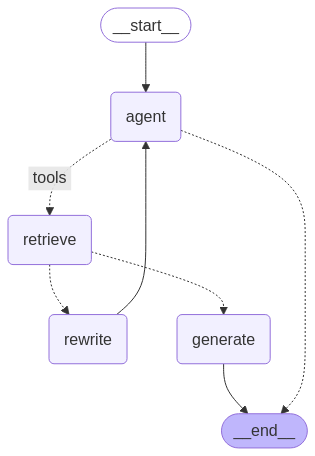

In [97]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

테스트 !

In [18]:
config = {"configurable": {"thread_id": "1"}}

In [19]:
for event in graph.stream(
    {
        "messages": [
            (
                "user",
                "안녕하세요! 오늘 날씨가 좋아요.",
            )
        ]
    },
    config,
    stream_mode="values",
):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

안녕하세요! 오늘 날씨가 좋아요.
##### HI ! #####
================================== Ai Message ==================================

안녕하세요! 좋은 날씨라니 기분이 좋으시겠어요. 오늘 특별한 계획이 있으신가요?


In [20]:
config = {"configurable": {"thread_id": "2"}}

In [21]:
for event in graph.stream(
    {
        "messages": [
            (
                "user",
                "최신 카카오",
            )
        ]
    },
    config,
    stream_mode="values",
):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

최신 카카오
##### HI ! #####
================================== Ai Message ==================================
Tool Calls:
  retrieve_ai_trends (call_hOels9lHyVLJLVIobfQqyZcf)
 Call ID: call_hOels9lHyVLJLVIobfQqyZcf
  Args:
    query: 카카오 최신 동향
##### CHECK RELEVANCE #####
question 최신 카카오
context 2025년
4월호
인공지능 산업의 최신 동향
---DECISION: DOCS NOT RELEVANT---
no
================================= Tool Message =================================
Name: retrieve_ai_trends

2025년
4월호
인공지능 산업의 최신 동향

🤖 검색 결과를 개선하기 위해 더 명확한 의도를 포함하여 질문을 다시 해주세요!:


In [22]:
graph.get_state(config).next

('rewrite',)

In [23]:
for event in graph.stream(
    Command(resume="카카오가 만든 카나나가 뭐지?"),
    config,
    stream_mode="values",
):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: retrieve_ai_trends

2025년
4월호
인공지능 산업의 최신 동향

🤖 검색 결과를 개선하기 위해 더 명확한 의도를 포함하여 질문을 다시 해주세요!:
feedback 카카오가 만든 카나나가 뭐지?
================================ Human Message =================================

카카오가 만든 카나나가 뭐지?
##### HI ! #####
================================== Ai Message ==================================
Tool Calls:
  retrieve_ai_trends (call_AMhUPXHLNrdMasF0eyFnZ29n)
 Call ID: call_AMhUPXHLNrdMasF0eyFnZ29n
  Args:
    query: 카카오 카나나
##### CHECK RELEVANCE #####
question 카카오가 만든 카나나가 뭐지?
context SPRi AI Brief 2025 년 4월호
20카카오 , 자체 개발 AI 모델 ‘카나나 ’의 테크니컬 리포트 공개
n카카오가 자체 개발 LLM ‘카나나 ’의 테크니컬 리포트를 공개하고 , 카나나에 단계별 사전학습과 
가지치기 , 지식증류 등의 학습 기법을 적용해 학습 효율성을 극대화했다고 설명  
n카카오는 연구 목적의 활용을 지원하기 위해 온디바이스 환경에서 작동될 수 있는 경량 모델 
‘카나나 나노 2.1B’ 를 오픈소스로 공개KEY Contents
£카나나 , 단계별 사전학습과 지식 증류 등의 학습 기법으로 학습 효율성 극대화
n카카오가 2025년 2월 27일 자체 개발 언어모델 ‘카나나 (Kanana)’ 의 구조와 학습 과정, 성능을 상세히 
다룬 테크니컬 리포트 *를 공개
* Kanana: Compute

c:\Users\pnylo\OneDrive\바탕 화면\Workspace\Langgraph_AIAgent_fastcampus\.conda\Lib\site-packages\langsmith\client.py:277: LangSmithMissingAPIKeyWarning: API key must be provided when using hosted LangSmith API
  warnings.warn(


response content="카나나는 카카오가 자체 개발한 대규모 언어 모델(LLM)로, 단계별 사전학습, 가지치기, 지식 증류 등의 기법을 통해 학습 효율성을 극대화한 모델입니다. 카카오는 다양한 크기의 카나나 모델 라인업을 구축했으며, 특히 한국어와 영어 성능에서 높은 평가를 받고 있습니다. 연구 목적으로 활용할 수 있도록 경량 모델인 '카나나 나노 2.1B'를 오픈소스로 공개했습니다." additional_kwargs={'refusal': None} response_metadata={'token_usage': {'completion_tokens': 117, 'prompt_tokens': 1077, 'total_tokens': 1194, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_f5bdcc3276', 'id': 'chatcmpl-BXiyLtaOkKvPx6tQ9W1YAnIlTH0g9', 'finish_reason': 'stop', 'logprobs': None} id='run-c2e4e457-894b-4d10-886c-13557518e94b-0' usage_metadata={'input_tokens': 1077, 'output_tokens': 117, 'total_tokens': 1194, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}
==========================

## 부록 ) Human in the loop 기본 예제

Human in the loop 

- 인간의 입력을 자동화된 프로세스에 통합하여 주요 단계에서 의사 결정, 검증 또는 수정에 인간이 개입
- 이는 기반 모델이 간헐적으로 부정확한 결과를 생성할 수 있는 LLM 기반 애플리케이션 에서 특히 유용

- `Interrupt` : 특정 노드에서 그래프를 일시 정지하고, 사용자에게 정보를 표시하고, 사용자의 입력을 받음

- `Command` : 그래프의 상태를 업데이트하고 노드에 메시지를 보내는 역할
    - resume : 실행을 재개할 값

In [1]:
import uuid
from typing import Optional
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.constants import START
from langgraph.graph import StateGraph
from langgraph.types import interrupt, Command


class State(TypedDict):
    """The graph state."""

    foo: str
    human_value: Optional[str]
    """Human value will be updated using an interrupt."""


def node(state: State):
    answer = interrupt(
        # This value will be sent to the client
        # as part of the interrupt information.
        "what is your age?"
    )
    print(f"> Received an input from the interrupt: {answer}")
    return {"human_value": answer}


graph_builder = StateGraph(State)
graph_builder.add_node("node", node)
graph_builder.add_edge(START, "node")

# A checkpointer must be enabled for interrupts to work!
checkpointer = MemorySaver()
graph = graph_builder.compile(checkpointer=checkpointer)

config = {
    "configurable": {
        "thread_id": uuid.uuid4(),
    }
}

for chunk in graph.stream({"foo": "abc"}, config):
    print(chunk)

{'__interrupt__': (Interrupt(value='what is your age?', resumable=True, ns=['node:0cb04baf-47c1-fbfd-0cd6-8b4e8c5e9dde']),)}


In [22]:
command = Command(resume="some input from a human!!!")

for chunk in graph.stream(Command(resume="some input from a human!!!"), config):
    print(chunk)

> Received an input from the interrupt: some input from a human!!!
{'node': {'human_value': 'some input from a human!!!'}}
